# Данные

In [71]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

corp_col = '#40ba21'


In [72]:

df = pd.read_csv("Never Trust Summary Statistics.tsv", delimiter="\t")
df["dataset"].unique()

array(['dino', 'away', 'h_lines', 'v_lines', 'x_shape', 'star',
       'high_lines', 'dots', 'circle', 'bullseye', 'slant_up',
       'slant_down', 'wide_lines'], dtype=object)

## Выберем в качестве бинарной переменной колонку dataset, присвоив 1 фигуре "wide_lines", остальным 0, то есть задача будет сводится к определению относится ли конкретная точка в массиве к фигуре "wide_lines" или нет.

In [73]:
df.loc[df["dataset"] != 'wide_lines', "dataset"] = 0
df.loc[df["dataset"] == 'wide_lines', "dataset"] = 1
df["dataset"] = df["dataset"].astype(int)

In [74]:
df

,dataset,x,y
0,0,55.384600,97.179500
1,0,51.538500,96.025600
2,0,46.153800,94.487200
3,0,42.820500,91.410300
4,0,40.769200,88.333300
...,...,...,...
1841,1,33.674442,26.090490
1842,1,75.627255,37.128752
1843,1,40.610125,89.136240
1844,1,39.114366,96.481751


# Домашнее задание 8. Решающее дерево.

## Обучающая и тестовая выборки.

Так как в общем наборе данных точки относящиеся к "wide_lines" составляют всего 8%, то есть массив не сбалансирован, то используем параметр stratify=y

In [75]:
from sklearn.model_selection import train_test_split

X = df.drop(['dataset'], axis=1) # X — признаки (features)
y = df[['dataset']]              # y — целевая переменная (label)

# Разделение на обучающую и тестовую выборки, так как в общем наборе данных точки относящиеся к "wide_lines" составляют всего 8%, то есть массив не сбалансирован, то используем параметр stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train

,x,y
1753,34.548619,26.111088
932,63.609380,83.360029
429,50.326911,90.022053
293,22.955093,70.426895
1617,61.737271,38.584844
...,...,...
175,28.236782,56.139596
458,50.333481,43.588671
413,56.772150,10.503272
1782,66.313810,98.931027


## Обучение базовой модели решающего дерева

### Так как объясняющие переменные это координаты и они в одном масштабе, то нет смысла использовать стандартизацию переменных.

### Кроме того, так как данные не сбалансированы, то укажем параметр class_weight='balanced'

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Базовое дерево
dtree_basic = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dtree_basic.fit(X_train, y_train)

# Оценка базовой модели
base_score = dtree_basic.score(X_test, y_test)
print(f"Базовая точность дерева: {base_score:.4f}")

Базовая точность дерева: 0.8865


### Функция рисования разделителяющих прямых

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



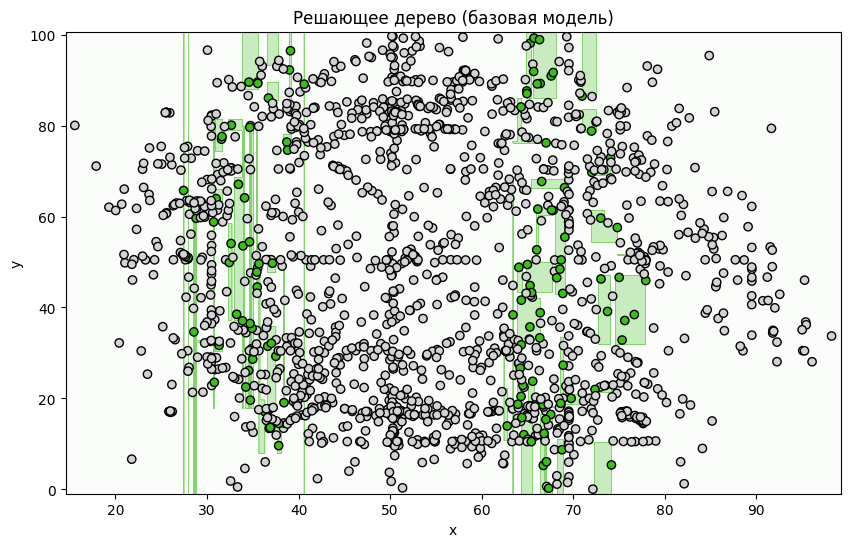

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_tree_boundary(model, X, y, title):
    h = 0.02  # Размер шага
    x_min, x_max = X['x'].min() - 1, X['x'].max() + 1
    y_min, y_max = X['y'].min() - 1, X['y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Создаем цветовую схему
    corp_green = '#40ba21'
    cmap_green = LinearSegmentedColormap.from_list('green_cmap', ['white', corp_green])
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_green)
    
    # Цвета точек: серый для 0, зеленый для 1
    colors = ['lightgray' if val == 0 else corp_green for val in y.values.ravel()]
    plt.scatter(X['x'], X['y'], c=colors, edgecolors='k')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

# Визуализация для лучшего дерева
plot_tree_boundary(dtree_basic, X_train, y_train, "Решающее дерево (базовая модель)")



### В целом видно что модель смогла определить оба региона с точками класса 1, но при этом регионы выглядят переобученными. Попробуем оптимизировать гиперпараметры, используя GridSearch. Оптимизировать параметры будем по параметру Recall, т.к. при оптимизации по Accuracy или Precision метод на имеющихся данных деградирует и выделяет одну небольшую квадратную зону.


In [78]:
# Параметры для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

# Поиск по сетке
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy', #'precision', Accuracy
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Лучшая модель
best_dtree = grid_search.best_estimator_
best_score = best_dtree.score(X_test, y_test)
print(f"Точность лучшей модели: {best_score:.4f}")

Лучшие параметры: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Точность лучшей модели: 0.9135


### Наилучшее значение параметров оказалось:

'class_weight': 'balanced' -- данные не сбалансированы, увеличивает вес редкого класса
'criterion': 'entropy' -- критерий энетропии (максимизирует информативность) лучше сработал
'max_depth': None -- неограниченная глубина дерева оптимальна
'min_samples_leaf': 1, 
'min_samples_split': 2

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



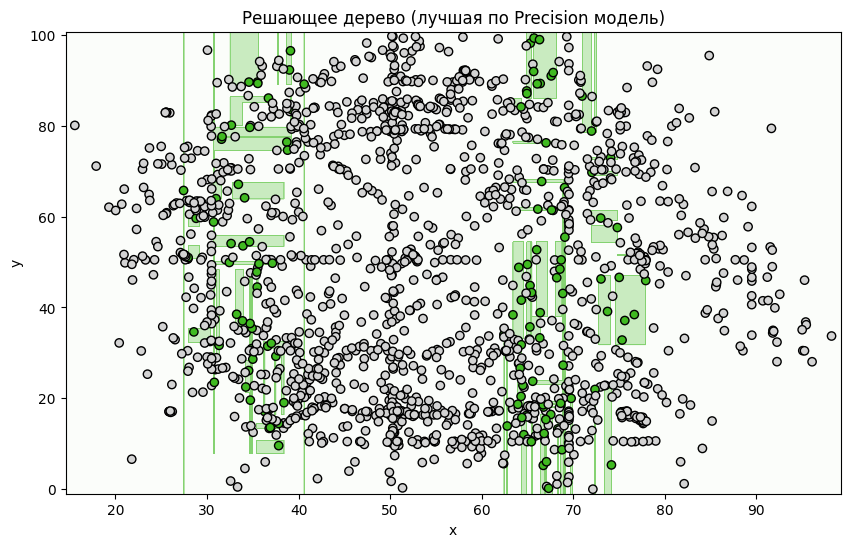

In [79]:
# Plot decision boundary for tuned model
plot_tree_boundary(best_dtree, X_train, y_train, "Решающее дерево (лучшая по Precision модель)")

### Регионы выбираются значительно точнее и специфичнее чем было для SVM, что видно как на тренировочной так и на тестовой выборке, но регионы выглядят несколько переобученными по сравнению с SVM.

f:\Staff\Иннополис\Innopolis\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



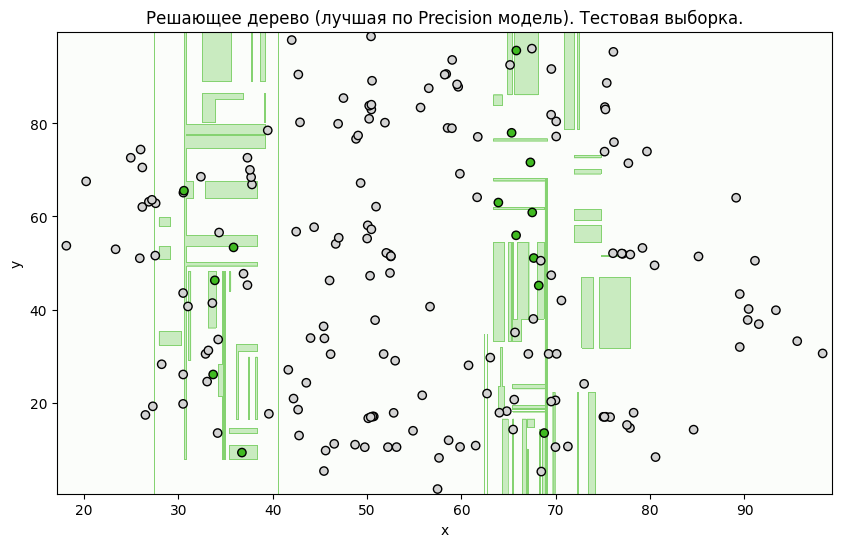

In [80]:
plot_tree_boundary(best_dtree, X_test, y_test, "Решающее дерево (лучшая по Precision модель). Тестовая выборка.")

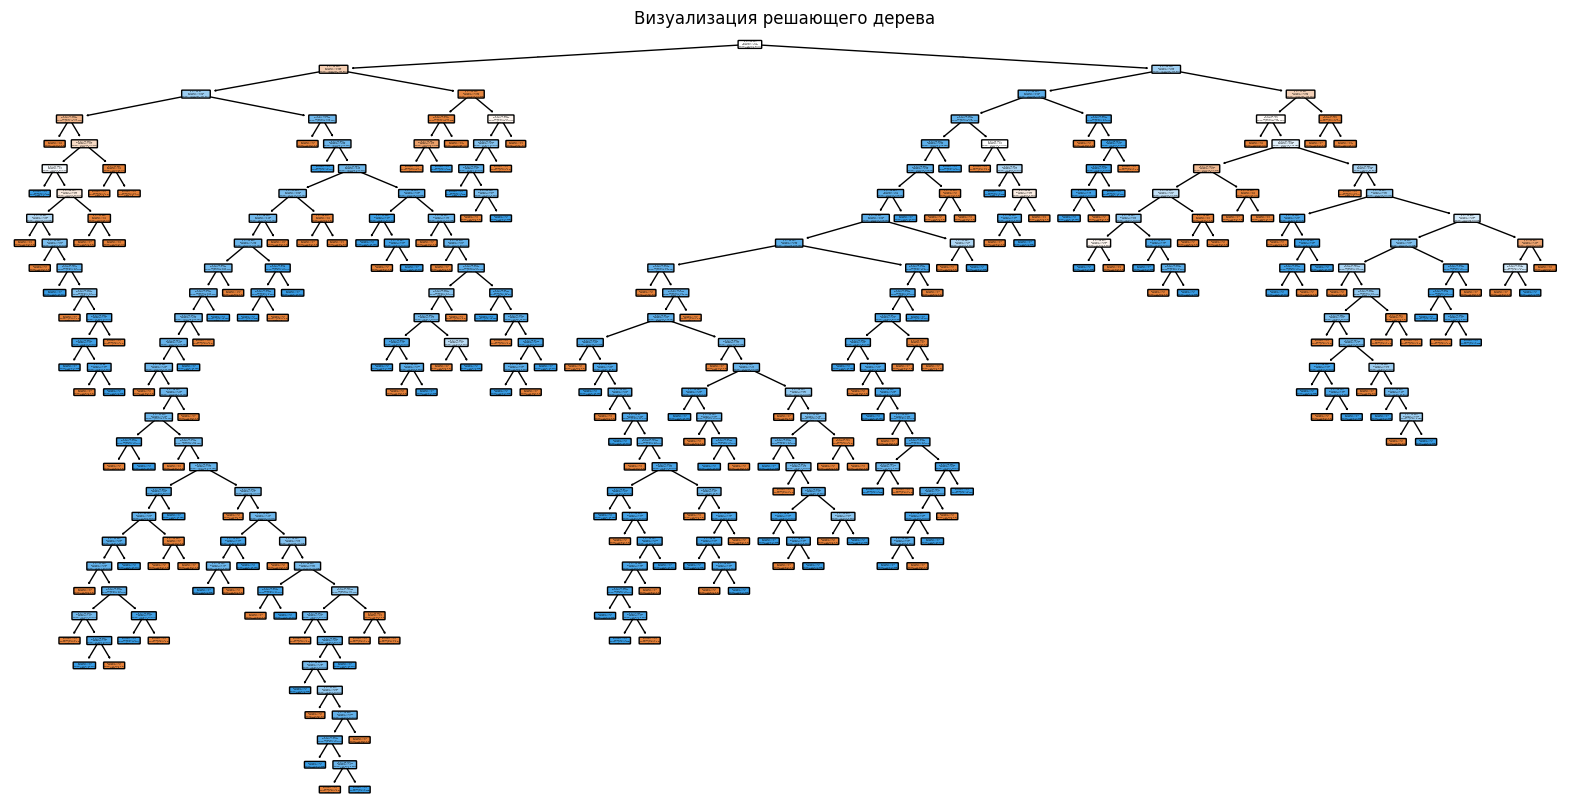

In [81]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(best_dtree, filled=True, feature_names=X.columns, 
          class_names=['0', '1'], rounded=True)
plt.title("Визуализация решающего дерева")
plt.show()

## Предсказание и матрица ошибок для базовой модели

In [82]:
predictions = dtree_basic.predict(X_test)

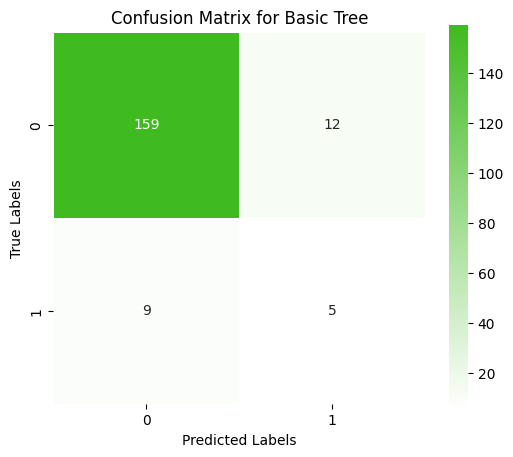

In [83]:
# Матрица ошибок для SVM
cm = confusion_matrix(y_test, predictions)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
from matplotlib.colors import LinearSegmentedColormap
c_map = LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Basic Tree")
plt.show()

In [84]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

# Ручной расчет метрик
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
specificity_manual = TN / (TN + FP)
f1_manual = 2 * ((precision_manual * recall_manual) / (precision_manual + recall_manual))
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)

print("\nМетрики:")
print(f"Прецизионность (Precision): {precision_manual:.3f}")
print(f"Полнота (Recall): {recall_manual:.3f}")
print(f"Специфичность (Specificity): {specificity_manual:.3f}")
print(f"F1-Score: {f1_manual:.3f}")
print(f"Общая точность (Accuracy): {accuracy_manual:.3f}")


Метрики:
Прецизионность (Precision): 0.294
Полнота (Recall): 0.357
Специфичность (Specificity): 0.930
F1-Score: 0.323
Общая точность (Accuracy): 0.886


### У базовой модели Precision на уровне 29%, что выше случйного гадания, но всё равно низкий результат (много ошибочно отнесённых к классу 1 точек), Recall на уровне 36% (было найдено 36% точек из класса 1).

## Предсказание и матрица ошибок для улучшенной модели

In [85]:
best_predictions = best_dtree.predict(X_test)

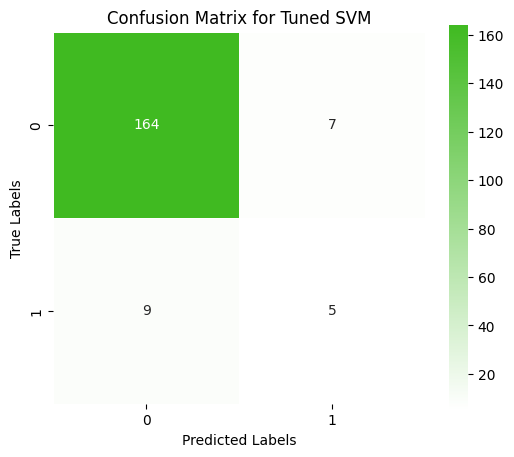

In [86]:

# Confusion matrix for tuned SVM
cm = confusion_matrix(y_test, best_predictions)

# Исходный зеленый цвет в HEX
hex_green_color = corp_col

# Преобразуем hex-код в tuple (R,G,B)
rgb_green_color = tuple(int(hex_green_color[i:i+2], 16)/255 for i in (1, 3, 5))  # конвертируем каждый байт из HEX в float

# Создаем градиент от белого (1,1,1) до нашего зеленого цвета
colors = [(1, 1, 1), rgb_green_color]

# Создаем линейную сегментированную цветовую карту
from matplotlib.colors import LinearSegmentedColormap
c_map = LinearSegmentedColormap.from_list("", colors)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap=c_map, linewidths=.5, square=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Tuned SVM")
plt.show()

In [87]:
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]
TN = cm[0, 0]

# Ручной расчет метрик
precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)
specificity_manual = TN / (TN + FP)
f1_manual = 2 * ((precision_manual * recall_manual) / (precision_manual + recall_manual))
accuracy_manual = (TP + TN) / (TP + TN + FP + FN)

print("\nМетрики:")
print(f"Прецизионность (Precision): {precision_manual:.3f}")
print(f"Полнота (Recall): {recall_manual:.3f}")
print(f"Специфичность (Specificity): {specificity_manual:.3f}")
print(f"F1-Score: {f1_manual:.3f}")
print(f"Общая точность (Accuracy): {accuracy_manual:.3f}")


Метрики:
Прецизионность (Precision): 0.417
Полнота (Recall): 0.357
Специфичность (Specificity): 0.959
F1-Score: 0.385
Общая точность (Accuracy): 0.914


### У оптимизированной модели Precision достиг 42%, но всё равно низкий результат (ошибочно отнесённых к классу 1 точек стало почти в два раза меньше), Recall же остался на прежнем уровне 36%. Тем не менее общая точность достигла 91%.

# Общие выводы

### Дерево решений в отличии от логистической регрессии оказалась способна на основе координат, хоть и с низкой Precision (41%, но выше чем у SVM 20%) выделить интересующую нас фигуру, recall также относительно невысок. Точность оказалась уже значительно выше уровня случайного гадания и SVM.

In [60]:
# График разброса
fig = px.scatter(df.loc[ df["dataset"] == 1, :], x='x', y='y', color_discrete_sequence=[corp_col], size_max=10)

# Фон и подписи
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Вещественная переменная X',
    yaxis_title='Вещественная переменная Y'
)

fig.show()